In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

#### 读取特征/标签的DataFrame
这部分定义了读取文件夹中的原始数据（经过降采样，1min为时间间隔）的函数
features就是压裂的pressure, rate, proppant concentration, total fluid volume, total proppant mass，label是distance（已经过散点平滑）

In [2]:
def get_stage_feature_label(stage):
    # 文件路径（是已经经过降采样1min为间隔的数据）
    feature_path = f'K:\\Sichuan\\H5\\resampled_feature_data\\resampled_feature_{stage}.csv'
    label_path = f'K:\\Sichuan\\H5\\resampled_label_data\\resampled_label_{stage}.csv'
    
    feature_df = pd.read_csv(feature_path, index_col=0)
    label_df = pd.read_csv(label_path, index_col=0)
    
    feature_df.index = pd.to_datetime(feature_df.index, format="%Y-%m-%d %H:%M:%S") # 压裂数据
    label_df.index = pd.to_datetime(label_df.index, format="%Y-%m-%d %H:%M:%S") # 微地震散点数据

    return feature_df, label_df

In [3]:
a, b = get_stage_feature_label(0)
print('读取的features表格和label表格：')
display(a, b)
# # plt.figure(figsize=(10, 5))
# # plt.plot(b['distance'])
#
# fig, ax = plt.subplots(figsize=(10, 5))
# for i in range(10):
#     _, b = get_stage_feature_label(i)
#     ax.plot(b['distance'].values, label=i)
#     ax.legend()

读取的features表格和label表格：


,pressure,rate,total_rate,prop,total_prop
time,,,,,
2017-03-09 08:16:55,35.61,0.000,0.00,0.0,0.00
2017-03-09 08:17:55,51.44,0.606,0.47,0.0,0.00
2017-03-09 08:18:55,52.99,1.201,1.48,0.0,0.00
2017-03-09 08:19:55,54.68,2.427,3.31,0.0,0.00
2017-03-09 08:20:55,54.41,2.410,5.73,0.0,0.00
...,...,...,...,...,...
2017-03-09 11:20:55,47.39,0.000,1947.77,0.0,120.26
2017-03-09 11:21:55,47.05,0.000,1947.77,0.0,120.26
2017-03-09 11:22:55,0.03,0.000,1947.77,0.0,120.26


,distance
time,
2017-03-09 08:16:55,0.000000
2017-03-09 08:17:55,4.086606
2017-03-09 08:18:55,8.173213
2017-03-09 08:19:55,12.259819
2017-03-09 08:20:55,16.346426
...,...
2017-03-09 11:20:55,189.217343
2017-03-09 11:21:55,189.217343
2017-03-09 11:22:55,189.217343


这里定义的是读取原始的微地震散点数据的函数
因为我们在后面生成额外的特征需要用到原始的散点数据

In [8]:
def get_stage_ms(stage_number):
    ms_path = '../dbscan_MS_data/'
    hf_path = '../stage_wise_HF_data/'
    ms_file = ms_path + f'H5_{stage_number}.csv'
    hf_file = hf_path + f'H5_HF_{stage_number}.csv'
    ms_df = pd.read_csv(ms_file, index_col=0)
    hf_df = pd.read_csv(hf_file, index_col=0)
    ms_df["time"] = pd.to_datetime(ms_df["time"], format="%Y-%m-%d %H:%M:%S") # 微地震散点数据
    hf_df["time"] = pd.to_datetime(hf_df["time"], format="%Y-%m-%d %H:%M:%S") # 压裂数据（连续）
    ms_df = ms_df[ms_df['time'] >= hf_df.loc[0, 'time']]
    return ms_df

In [9]:
mm = get_stage_ms(0)
mm

,Well,Stage,time,x,y,z,Magnitude,distance
0,H5-4,1,2017-03-09 09:09:25,359.4,-2158.4,3440.2,-1.14,126.61
1,H5-4,1,2017-03-09 09:21:37,172.7,-2112.8,3465.5,-1.11,74.57
2,H5-4,1,2017-03-09 09:46:14,404.5,-2205.7,3543.6,-1.96,208.09
3,H5-4,1,2017-03-09 09:58:55,367.8,-2114.7,3439.1,-0.28,127.70
4,H5-4,1,2017-03-09 09:59:36,284.1,-2128.8,3416.6,-1.32,48.58
5,H5-4,1,2017-03-09 10:07:08,366.3,-2195.2,3504.9,-1.69,155.34
6,H5-4,1,2017-03-09 10:12:55,184.5,-2134.6,3507.0,-1.52,89.50
7,H5-4,1,2017-03-09 10:45:01,212.4,-2118.3,3466.1,-1.51,44.45
8,H5-4,1,2017-03-09 10:47:08,306.4,-2219.1,3478.7,-0.71,92.75
9,H5-4,1,2017-03-09 10:52:05,223.4,-2156.1,3504.9,-1.90,70.62


In [10]:
# 跳过32, 因为32段有问题，还没压裂就有地震！跳过45，因为45两个对不上！
stage_list = list(range(32)) + list(range(33, 45)) + list(range(46, 73))
print(len(stage_list))
print('应该有73个')

71
应该有73个


#### 步骤
每个段看成单独的数据集，进行时间窗划分样本，并进行特征的缩放。最后在把所有的样本放到一个大数据集中
tip: 应该在每个段上单独进行MIN-MAX SCALING(除了stress shadow effect是整口井)，在拼装成整个数据集

In [11]:
import torch
import torch.nn as nn
from torch import optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader, TensorDataset, ConcatDataset
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

这里是记录所有段的 震级/微地震数量 放到一个列表中
方便后面把他作为额外的特征‘stress shadow effect’加入到特征中

[-30.67, -46.56999999999999, -75.03, -64.66, -61.46, -154.72, -76.93999999999998, -245.91999999999996, -493.30999999999995, -255.33000000000004, -255.28999999999996, -556.51, -440.45, -272.41, -607.98, -623.39, -462.6, -465.84, -425.76, -691.77, -1236.02, -2043.79, -2065.52]
[1.0, 0.9835240912849018, 0.9548058054169282, 0.786719660520575, 0.7347717379394156, 0.9247228281983085, 0.8182569803464523, 0.7170905178854257, 0.7509587703832094, 0.7576726533783582, 0.5053442110191356, 0.7769078285469523, 0.7011027104563249, 0.507864407455, 0.3500283895645937, 0.2250744603492415, 0.0, 0.6871171144248872, 0.25711980396258555, 0.599996015499706, 0.4265806014603194, 0.6071681160286485, 0.539610913546305]
23 27 23


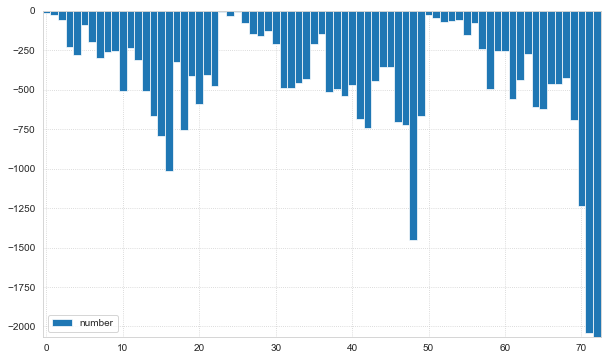

In [34]:
num_ms = []
for stage in stage_list:
    ms_df = get_stage_ms(stage)
    num = ms_df['Magnitude'].sum()
    # num = num / len(ms_df)
    # num = len(ms_df)
    num_ms.append(num)
# print(num_ms)
num_ms.insert(32, num_ms[31])
num_ms.insert(45, num_ms[44])
well_4 = num_ms[:23]
well_5 = num_ms[23:50]
well_6 = num_ms[50:]
print(well_6)
def min_max_scaling(input_list):
    max_value = max(input_list)
    min_value = min(input_list)
    scaled_list = [(element - min_value) / (max_value - min_value) for element in input_list]
    return scaled_list
well_4 = min_max_scaling(well_4)
well_5 = min_max_scaling(well_5)
well_6 = min_max_scaling(well_6)
print(well_4)
print(len(well_4), len(well_5), len(well_6))
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(np.arange(73), num_ms, width=1, edgecolor="white", linewidth=0.7, label='number')
ax.grid(linestyle=':')
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
ax.vlines((22, 49), -2.0, 0.0, colors='r', linestyles='--')
ax.legend()

**这部分是生成数据集的主要部分**
首先定义了`make_stage_dataset`在每个段上添加额外的特征，并进行时间窗的样本划分，再进行特征的缩放，该函数返回的`stage_dataset`是某段上的数据集
接着用`ConcatDataset`方法把所有*训练段*和*测试段*上的数据集拼接成总的*训练集*和*测试集*

In [52]:
# ----------再每个段上单独划分成训练集----------
time_window = 10    # 时间步长为多少
scaler = MinMaxScaler(feature_range=(0, 1))

def make_stage_dataset(stage_idx, time_window_width=time_window):
    # 载入原始输入并转换为 numpy 数组
    feature_df, label_df = get_stage_feature_label(stage_idx)
    original_ms = get_stage_ms(stage_idx)
    length = len(label_df)

    # 加入"额外"的特征
    # feature_df['injectivity'] = feature_df['rate'] / feature_df['pressure']    # 增加 injectivity 作为特征
    if stage_idx == 0 or stage_idx == 23 or stage_idx == 50:
        feature_df['stress shadow'] = 0.0
    elif stage_idx < 23:
        feature_df['stress shadow'] = well_4[stage_idx-1]
    elif 23 < stage_idx < 50:
        feature_df['stress shadow'] = well_5[stage_idx-24]
    elif stage_idx > 50:
        feature_df['stress shadow'] = well_6[stage_idx-51]

    # 按时间窗划分后重新组装成整体数组并归一化
    x_temp = np.zeros((1, 7))
    y_temp = np.zeros((1, 1))
    for i in range(length):
        end_idx = i + time_window_width
        if end_idx > length:
            break
        x_df = feature_df.copy().iloc[i:end_idx, :]
        time_idx = x_df.index[-1]
        time_begin_idx = x_df.index[-time_window]
        ms_acc_num = len(original_ms[(original_ms['time'] >= time_begin_idx) & (original_ms['time'] <= time_idx)])
        ms_acc_mag = original_ms[(original_ms['time'] >= time_begin_idx) & (original_ms['time'] <= time_idx)]['Magnitude'].sum()
        x_df['acc_ms_mag'] = ms_acc_mag
        x_df['acc_ms_num'] = ms_acc_num
        y_df = label_df.copy().iloc[end_idx-1]
        feature_array_to_append = np.array(x_df, dtype=np.float32)
        label_array_to_append = np.array(y_df, dtype=np.float32).reshape(1, 1)
        x_temp = np.append(x_temp, feature_array_to_append, axis=0)
        y_temp = np.append(y_temp, label_array_to_append, axis=0)
    feature_array = np.delete(x_temp, 0, axis=0)
    label_array = np.delete(y_temp, 0, axis=0)
    # feature_array_to_scale = np.concatenate((feature_array[:, 0:5], feature_array[:, 6:8].reshape(-1, 2)), axis=1)

    feature_array_final = scaler.fit_transform(feature_array)

    # feature_array_final = np.concatenate((feature_array_scaled[:, :], feature_array[:, 5].reshape(-1, 1)), axis=1)
    label_array_final = scaler.fit_transform(label_array)
    # features rank: 1, 2, 3, 4, 5, acc_num_till_now, stress shadow effect

    # 组装成tensor dataset
    x_list = []
    y_list = []
    iter_num = label_array.shape[0]
    for j in range(iter_num):
        x_array_to_append = feature_array_final[j*time_window_width:(j+1)*time_window_width,:]
        y_array_to_append = label_array_final[j,:].reshape(1, 1)
        x_list.append(x_array_to_append)
        y_list.append(y_array_to_append)

    # # 转化为 tensor, 用 TensorDataset 直接转化成数据集（一个段的）
    x_tensor = torch.tensor(np.array(x_list), dtype=torch.float32)
    y_tensor = torch.tensor(np.array(y_list), dtype=torch.float32).view(-1, 1, 1)
    stage_dataset = TensorDataset(x_tensor, y_tensor)
    return stage_dataset

#----------组装----------
import random
from math import ceil

random.seed(10)
frac_number = 0.8    # 取 80% 作为训练集
train_stage_number = ceil(len(stage_list) * frac_number)
train_stage_list = random.sample(stage_list, train_stage_number)      # 训练集段号
test_stage_list = list(set(stage_list) - set(train_stage_list))       # 测试集段号
print(f'training stage number: {len(train_stage_list)}, '
      f'testing stage number: {len(test_stage_list)}\ntesting stages: {test_stage_list}')

whole_train_dataset_list = []
whole_test_dataset_list = []

for train_stage in train_stage_list:
    train_stage_dataset = make_stage_dataset(train_stage)
    whole_train_dataset_list.append(train_stage_dataset)

for test_stage in test_stage_list:
    test_stage_dataset = make_stage_dataset(test_stage)
    whole_test_dataset_list.append(test_stage_dataset)

whole_train_dataset = ConcatDataset(whole_train_dataset_list)
whole_test_dataset = ConcatDataset(whole_test_dataset_list)
print('-'*50)
print(f'total training samples: {len(whole_train_dataset)}')
print(f'total testing samples: {len(whole_test_dataset)}')

training stage number: 57, testing stage number: 14
testing stages: [3, 35, 5, 37, 38, 40, 59, 69, 43, 12, 50, 25, 58, 27]
--------------------------------------------------
total training samples: 10441
total testing samples: 2469


In [14]:
# import random
# from math import ceil
#
# random.seed(99)
# frac_number = 0.95    # 取 80% 作为训练集
# train_stage_number = ceil(len(stage_list) * frac_number)
# train_stage_list = random.sample(stage_list, train_stage_number)      # 训练集段号
# test_stage_list = list(set(stage_list) - set(train_stage_list))       # 测试集段号
# print(f'training stage number: {len(train_stage_list)}, '
#       f'testing stage number: {len(test_stage_list)}\ntesting stages: {test_stage_list}')
#
# scaler = MinMaxScaler(feature_range=(0, 1))
#
# def make_training_dataset(time_window_width=time_window):
#     x_temp = np.zeros((1, 6))
#     y_temp = np.zeros((1, 1))
#     for training_stage in train_stage_list:
#         feature_array_to_append, label_array_to_append = make_stage_array(training_stage)
#         x_temp = np.append(x_temp, feature_array_to_append, axis=0)
#         y_temp = np.append(y_temp, label_array_to_append, axis=0)
#     feature_array = np.delete(x_temp, 0, axis=0)
#     label_array = np.delete(y_temp, 0, axis=0)
#     feature_array = scaler.fit_transform(feature_array)
#     label_array = scaler.fit_transform(label_array)
#     x_list = []
#     y_list = []
#     for i in range(label_array.shape[0]):
#         feature_array_slice = feature_array[i*time_window_width: (i+1)*time_window_width, :]
#         label_array_slice = label_array[i]
#         x_list.append(feature_array_slice)
#         y_list.append(label_array_slice)
#     x_tensor = torch.tensor(x_list, dtype=torch.float32)
#     y_tensor = torch.tensor(y_list, dtype=torch.float32).view(-1, 1, 1)
#     training_tensor_dataset = TensorDataset(x_tensor, y_tensor)
#     return training_tensor_dataset
#
# def make_testing_dataset(time_window_width=time_window):
#     x_temp = np.zeros((1, 6))
#     y_temp = np.zeros((1, 1))
#     for testing_stage in test_stage_list:
#         feature_array_to_append, label_array_to_append = make_stage_array(testing_stage)
#         x_temp = np.append(x_temp, feature_array_to_append, axis=0)
#         y_temp = np.append(y_temp, label_array_to_append, axis=0)
#     feature_array = np.delete(x_temp, 0, axis=0)
#     label_array = np.delete(y_temp, 0, axis=0)
#     feature_array = scaler.fit_transform(feature_array)
#     label_array = scaler.fit_transform(label_array)
#     x_list = []
#     y_list = []
#     for i in range(label_array.shape[0]):
#         feature_array_slice = feature_array[i*time_window_width: (i+1)*time_window_width, :]
#         label_array_slice = label_array[i]
#         x_list.append(feature_array_slice)
#         y_list.append(label_array_slice)
#     x_tensor = torch.tensor(np.array(x_list), dtype=torch.float32)
#     y_tensor = torch.tensor(np.array(y_list), dtype=torch.float32).view(-1, 1, 1)
#     testing_tensor_dataset = TensorDataset(x_tensor, y_tensor)
#     return testing_tensor_dataset


某样本的features（time_step x num_of_features）和label（1x1）张量如下

In [53]:
whole_train_dataset[99][0]

tensor([[0.9112, 0.9985, 0.4952, 0.5040, 0.3346, 0.3851, 0.5862],
        [0.9200, 0.9979, 0.5021, 0.6710, 0.3510, 0.3851, 0.5862],
        [0.8961, 0.9987, 0.5091, 0.6112, 0.3675, 0.3851, 0.5862],
        [0.8745, 0.9997, 0.5160, 0.0000, 0.3700, 0.3851, 0.5862],
        [0.8899, 0.9989, 0.5230, 0.0000, 0.3700, 0.3851, 0.5862],
        [0.9139, 0.9987, 0.5299, 0.7340, 0.3779, 0.3851, 0.5862],
        [0.9139, 0.9988, 0.5368, 0.7516, 0.3961, 0.3851, 0.5862],
        [0.8873, 0.9999, 0.5438, 0.0000, 0.4105, 0.3851, 0.5862],
        [0.8750, 0.9980, 0.5507, 0.0000, 0.4105, 0.3851, 0.5862],
        [0.8978, 0.9992, 0.5577, 0.0000, 0.4105, 0.3851, 0.5862]])

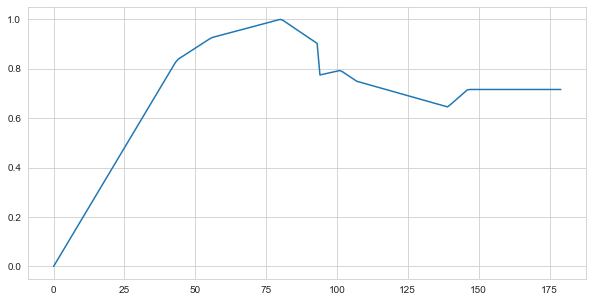

In [40]:
true_value = []
for sample in make_stage_dataset(0):
    temp = sample[1].item()
    true_value.append(temp)
plt.figure(figsize=(10, 5))
plt.plot(true_value)


#### 载入数据，利用LSTM进行训练
input tensor (batch_size, sequence length, input_size)   
output tensor (batch_size, sequence length, hidden_size)   
h0, c0 tensor (num_layers, batch_size, hidden_size)

In [54]:
batch_size = 32
train_loader = DataLoader(dataset=whole_train_dataset, shuffle=False, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(dataset=whole_test_dataset, shuffle=False, batch_size=batch_size, drop_last=True)

LSTM模型，随时间变化的5个压裂特征输入到LSTM层中，静态的特征在LSTM层后进行张量拼接，最后放入全连接层进行预测

In [55]:
class my_LSTM(nn.Module):
    def __init__(self, hidden_size):
        super(my_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=5, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(in_features=hidden_size+2, out_features=1)

    def forward(self, x):
        h0 = torch.zeros(1, x.shape[0], self.hidden_size)
        c0 = torch.zeros(1, x.shape[0], self.hidden_size)
        lstm_out, _ = self.lstm(x[:, :, 0:5], (h0,c0))
        combined = torch.cat((lstm_out[:,-1,:].view(x.shape[0], 1, self.hidden_size), x[:,-1,5:].view(x.shape[0], 1, 2)), dim=2)
        prediction = self.fc(combined).view(x.shape[0], 1, 1)
#         prediction = self.fc(lstm_out)[:,-1,:]
        return prediction

# class my_LSTM(nn.Module):
#     def __init__(self, hidden_size):
#         super(my_LSTM, self).__init__()
#         self.hidden_size = hidden_size
#         self.lstm = nn.LSTM(input_size=6, hidden_size=hidden_size, num_layers=1, batch_first=True)
#         self.fc = nn.Linear(in_features=hidden_size, out_features=1)
#
#     def forward(self, x):
#         h0 = torch.zeros(1, x.shape[0], self.hidden_size)
#         c0 = torch.zeros(1, x.shape[0], self.hidden_size)
#         lstm_out, _ = self.lstm(x, (h0,c0))
#         prediction = self.fc(lstm_out[:,-1,:]).view(x.shape[0], 1, 1)
#         #         prediction = self.fc(lstm_out)[:,-1,:]
#         return prediction

In [56]:
# 超参数设置
hidden_neurons = 10
learning_rate = 0.01

model = my_LSTM(hidden_neurons)
model.to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [57]:
epochs = 50
# 记录 loss
batch_loss_list = []
epoch_loss_list = []
test_loss_list = []

n_batches = len(train_loader)
n_test_batches = len(test_loader)

begin_time = time.time()

for epoch in range(epochs):
    acc_loss = 0.0
    acc_test_loss = 0.0
    
    for batch, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        y = y.view(batch_size, 1, 1)
        # 计算误差
        pred = model(x)
        loss = loss_fn(pred, y)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差（每个batch和整个epoch）
        batch_loss_list.append(loss.item())
        acc_loss += loss.item()
    epoch_loss_value = acc_loss / n_batches
    epoch_loss_list.append(epoch_loss_value)
    
    print(f'epoch {epoch+1}: last loss = {loss.item():.5f}, average loss = {epoch_loss_value:.5f}')
    
    with torch.no_grad():
        for test_batch, (test_x, test_y) in enumerate(test_loader):
            test_x = test_x.to(device)
            test_y = test_y.to(device)
            
            test_pred = model(test_x)
            test_loss = loss_fn(test_pred, test_y)
            acc_test_loss += test_loss.item()
    test_loss_value = acc_test_loss / n_test_batches
    test_loss_list.append(test_loss_value)
    
    print(f'loss on test: {test_loss_value:.5f}')
    print('*'*50)
            
print(f'Training done in {(time.time()-begin_time):.2f}s')

model_save_path = f'K:\\Sichuan\\H5\\model_save_dict\\smoothed_t{time_window}_batch{batch_size}_\
hidden{hidden_neurons}_loss{test_loss_value:.5f}.pth'
torch.save(model.state_dict(), model_save_path)

print('Model saved.')

epoch 1: last loss = 0.00062, average loss = 0.04209
loss on test: 0.03161
**************************************************
epoch 2: last loss = 0.00052, average loss = 0.02169
loss on test: 0.03163
**************************************************
epoch 3: last loss = 0.00049, average loss = 0.02102
loss on test: 0.03097
**************************************************
epoch 4: last loss = 0.00048, average loss = 0.02054
loss on test: 0.03040
**************************************************
epoch 5: last loss = 0.00048, average loss = 0.02021
loss on test: 0.03020
**************************************************
epoch 6: last loss = 0.00048, average loss = 0.01998
loss on test: 0.03025
**************************************************
epoch 7: last loss = 0.00047, average loss = 0.01980
loss on test: 0.03028
**************************************************
epoch 8: last loss = 0.00046, average loss = 0.01966
loss on test: 0.03023
*******************************************

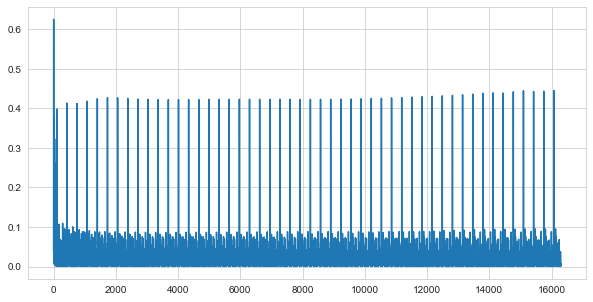

In [58]:
plt.figure(figsize=(10, 5))
plt.plot(batch_loss_list)

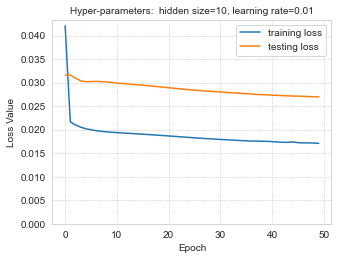

In [59]:
fig, ax = plt.subplots(figsize=(5, 3.75))
ax.plot(epoch_loss_list, label='training loss')
ax.plot(test_loss_list, label='testing loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss Value')
ax.set_ylim(bottom=0)
ax.grid(linestyle=':', c='grey', alpha=0.5)
ax.set_title(f'Hyper-parameters:  hidden size={hidden_neurons}, learning rate={learning_rate}', fontsize=10)
ax.legend()
fig.savefig(f'K:\\Sichuan\\H5\\training_images\\loss--smoothed_t{time_window}_batch{batch_size}_\
hidden{hidden_neurons}_loss{test_loss_value:.5f}.png', 
            dpi=300, bbox_inches="tight", pad_inches=0.1)

#### 对比预测值和真实值

In [60]:
# 在 CPU 上进行评估
device = torch.device('cpu')
model = my_LSTM(hidden_neurons)
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.eval()

my_LSTM(
  (lstm): LSTM(5, 10, batch_first=True)
  (fc): Linear(in_features=12, out_features=1, bias=True)
)

(2464, 1) (2469, 1)


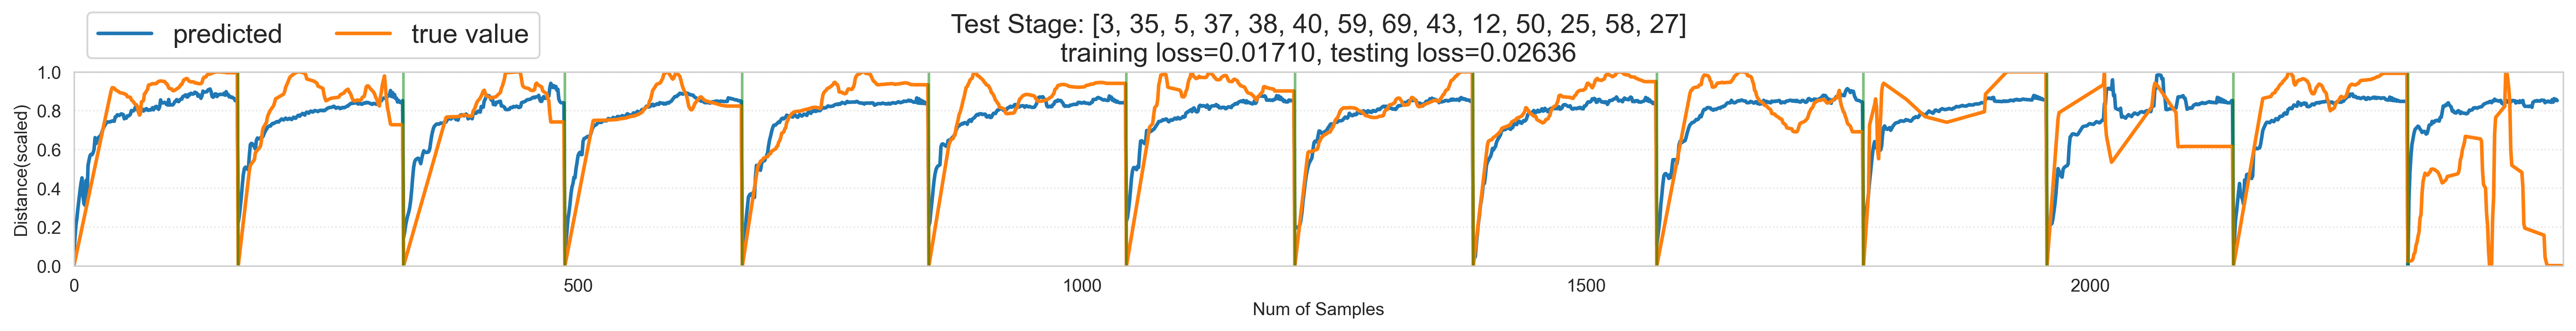

In [26]:
test_predictions = []
with torch.no_grad():
    for test_batch, (test_x, test_y) in enumerate(test_loader):
        test_x = test_x.to(device)
        test_y = test_y.to(device)
        test_y = test_y.view(batch_size, 1, 1)

        test_pred = model(test_x)
        test_predictions.append(test_pred.view(batch_size, 1).numpy())
test_predictions = np.array(test_predictions)
test_predictions = test_predictions.reshape(-1, 1)

test_data = []
for test_stage in test_stage_list:
    test_data_temp = make_stage_dataset(test_stage)
    test_data.append(test_data_temp)
test_set = ConcatDataset(test_data)
true_value_list = []
for sample in range(len(test_set)):
    true_value = test_set.__getitem__(sample)[1].item()
    true_value_list.append(true_value)
true_value_list = np.array(true_value_list).reshape(-1, 1)

print(test_predictions.shape, true_value_list.shape)

fig, ax = plt.subplots(figsize=(25, 2), dpi=300)
line1, = ax.plot(test_predictions, label='predicted')
line2, = ax.plot(true_value_list, label='true value', linestyle='-')
line1.set_linewidth(2.0)
line2.set_linewidth(2.0)
ax.set_xlabel('Num of Samples')
ax.set_ylabel('Distance(scaled)')
ax.set_ylim(0, 1.0)
ax.set_xlim(0, len(true_value_list))
acc_pos = 0.0
for stg in test_data[:-1]:
    lgth = len(stg)
    acc_pos += lgth
    ax.vlines(acc_pos, 0, 1.5, colors='g', linestyles='-', alpha=0.5)
ax.grid(axis='y', linestyle=':', c='grey', alpha=0.2)
ax.grid(axis='x', alpha=0.0)
ax.set_title(f'Test Stage: {test_stage_list}\n\
training loss={epoch_loss_value:.5f}, testing loss={test_loss_value:.5f}', fontsize=15)
ax.legend(bbox_to_anchor=(0.0,1.0), loc="lower left", ncol=2, fontsize=15)
fig.savefig(f'K:\\Sichuan\\H5\\training_images\\test--smoothed_t{time_window}_batch{batch_size}_\
hidden{hidden_neurons}_loss{test_loss_value:.5f}.png',
            dpi=300, bbox_inches="tight", pad_inches=0.1)

(2464, 1) (2469, 1)


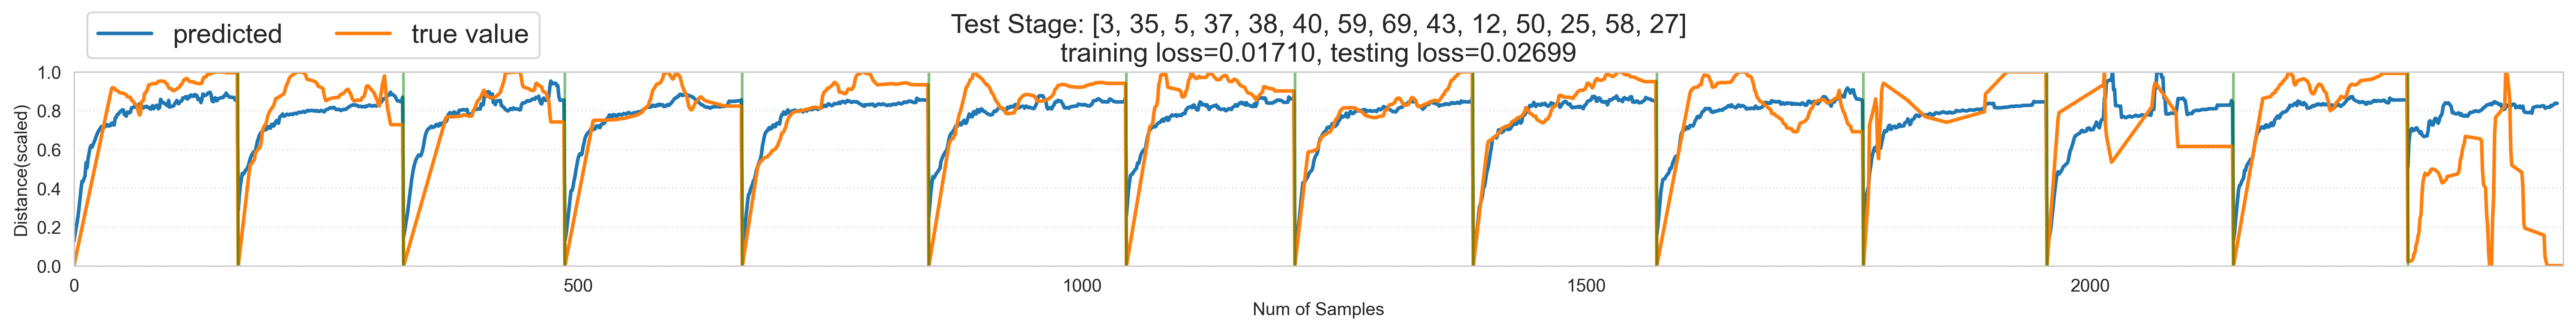

In [61]:
test_predictions = []
with torch.no_grad():
    for test_batch, (test_x, test_y) in enumerate(test_loader):
        test_x = test_x.to(device)
        test_y = test_y.to(device)
        test_y = test_y.view(batch_size, 1, 1)

        test_pred = model(test_x)
        test_predictions.append(test_pred.view(batch_size, 1).numpy())
test_predictions = np.array(test_predictions)
test_predictions = test_predictions.reshape(-1, 1)

test_data = []
for test_stage in test_stage_list:
    test_data_temp = make_stage_dataset(test_stage)
    test_data.append(test_data_temp)
test_set = ConcatDataset(test_data)
true_value_list = []
for sample in range(len(test_set)):
    true_value = test_set.__getitem__(sample)[1].item()
    true_value_list.append(true_value)
true_value_list = np.array(true_value_list).reshape(-1, 1)

print(test_predictions.shape, true_value_list.shape)

fig, ax = plt.subplots(figsize=(25, 2), dpi=300)
line1, = ax.plot(test_predictions, label='predicted')
line2, = ax.plot(true_value_list, label='true value', linestyle='-')
line1.set_linewidth(2.0)
line2.set_linewidth(2.0)
ax.set_xlabel('Num of Samples')
ax.set_ylabel('Distance(scaled)')
ax.set_ylim(0, 1.0)
ax.set_xlim(0, len(true_value_list))
acc_pos = 0.0
for stg in test_data[:-1]:
    lgth = len(stg)
    acc_pos += lgth
    ax.vlines(acc_pos, 0, 1.5, colors='g', linestyles='-', alpha=0.5)
ax.grid(axis='y', linestyle=':', c='grey', alpha=0.2)
ax.grid(axis='x', alpha=0.0)
ax.set_title(f'Test Stage: {test_stage_list}\n\
training loss={epoch_loss_value:.5f}, testing loss={test_loss_value:.5f}', fontsize=15)
ax.legend(bbox_to_anchor=(0.0,1.0), loc="lower left", ncol=2, fontsize=15)
fig.savefig(f'K:\\Sichuan\\H5\\training_images\\test--smoothed_t{time_window}_batch{batch_size}_\
hidden{hidden_neurons}_loss{test_loss_value:.5f}.png',
            dpi=300, bbox_inches="tight", pad_inches=0.1)